<h3> 🌌 Dataset Description</h3>

<p>You will have access to a training set and a test set. The training set contains the position and velocity measurements of the three bodies for different time steps. You sholid use this data to train your model and learn to propagate the trajectories of the objects. The test set contains an initial position and several time steps. Using your trained model, you sholid predict the positions of the three objects starting from the initial position. Additionally, you have access to a sample submission. This is an example of what your submission files sholid look like so that the system can accept them.</p>

<h5>📁 Files</h5>
<ul>
  <li><code>X_train.csv</code> — training set (1,285,000 rows, 14 cols; 5000 trajectories × 257 timesteps)</li>
  <li><code>X_test.csv</code> — test set (1,041,621 rows, 8 cols; 4053 trajectories × 257 timesteps)</li>
  <li><code>sample_submission.csv</code> — example in the correct format (random predictions)</li>
</ul>

<h4>X_train Columns</h4>
<ul>
  <li><code>Id</code> — row index (use <code>traj_id = Id // 257</code>)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x_1, y_1, v_x_1, v_y_1</code> — position/velocity of object 1</li>
  <li><code>x_2, y_2, v_x_2, v_y_2</code> — position/velocity of object 2</li>
  <li><code>x_3, y_3, v_x_3, v_y_3</code> — position/velocity of object 3</li>
</ul>

<h4>X_test Columns</h4>
<ul>
  <li><code>Id</code> — row id (257 rows per trajectory)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x0_1, y0_1</code> — object 1 initial position (t=0)</li>
  <li><code>x0_2, y0_2</code> — object 2 initial position (t=0)</li>
  <li><code>x0_3, y0_3</code> — object 3 initial position (t=0)</li>
</ul>

<p><b>Note:</b> After a collision, remaining rows in that trajectory are zero-padded (features become zero; <code>t</code> may be 0). Exclude these rows when training/validating.</p>



<h3>📚 Imports</h3>

In [59]:
import matplotlib.pyplot as pyplot   # Library for plotting graphs and visualizations
import numpy as np                   # Library for numerical computing (arrays, math functions)
import pandas as pd                  # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
import time                                            # Python built-in library to measure execution time


<h3>📂 Load Data</h3>

In [60]:
data = pd.read_csv("~/Downloads/X_train.csv")
test = pd.read_csv("~/Downloads/X_test.csv")

In [61]:
data.head()  # Display the first few rows of the dataset to understand its structure

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [62]:
data.columns  # List all column names to identify features and target variable

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [63]:
idx = np.hstack((0,data[data.t==10].index.values +1))  # Indices where each trajectory starts (t=0)
idx.shape, data.t.min(), data.t.max()  # Check number of trajectories and time range

((4054,), np.float64(0.0), np.float64(10.0))

3113


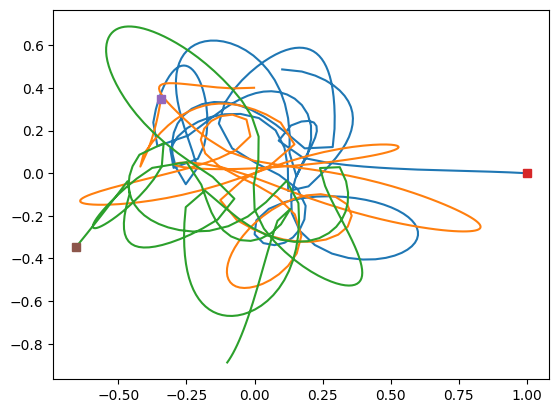

In [64]:
k = np.random.randint(idx.shape[0])  # Pick a random trajectory index
print(k)
plitdx = range(idx[k],257+idx[k])  # Get the row indices for that trajectory
pltsquare = idx[k]   # Determine the subplot position based on trajectory index
plt.plot(data.x_1[plitdx],data.y_1[plitdx])  # Plot the trajectory of object 1
plt.plot(data.x_2[plitdx],data.y_2[plitdx])  # Plot the trajectory of object 2
plt.plot(data.x_3[plitdx],data.y_3[plitdx])  # Plot the trajectory of object 3

plt.plot(data.x_1[pltsquare],data.y_1[pltsquare],'s')  # Mark the starting point of object 1
plt.plot(data.x_2[pltsquare],data.y_2[pltsquare],'s')  # Mark the starting point of object 2
plt.plot(data.x_3[pltsquare],data.y_3[pltsquare],'s')  # Mark the starting point of object 3

<h2>📝 Task 1</h2>
<h3>Task 1.1</h3>

<h3>🧩 Preprocessing (trajectory id, padding, initial conditions)(Reusable)</h3>

In [65]:
def add_traj_id(df: pd.DataFrame, steps_per_traj: int = 257) -> pd.DataFrame:
    """Adiciona traj_id assumindo N linhas fixas por trajetória."""
    out = df.copy()
    out["traj_id"] = (out["Id"] // steps_per_traj).astype(np.int32)
    return out

def mark_padding(df: pd.DataFrame) -> pd.DataFrame:
    """Assinala linhas de padding pós-colisão (todas as features = 0)."""
    out = df.copy()
    feat_cols = [
        'x_1','y_1','v_x_1','v_y_1',
        'x_2','y_2','v_x_2','v_y_2',
        'x_3','y_3','v_x_3','v_y_3'
    ]
    out["is_padding"] = (out[feat_cols].abs().sum(axis=1) == 0)
    return out

def add_initial_positions(df: pd.DataFrame) -> pd.DataFrame:
    """Extrai posições iniciais (t mínimo por trajetória) e junta como x0_*, y0_*."""
    out = df.copy()
    first = out.loc[out.groupby("traj_id")["t"].idxmin(),
                    ["traj_id","x_1","y_1","x_2","y_2","x_3","y_3"]].rename(columns={
        "x_1":"x0_1","y_1":"y0_1",
        "x_2":"x0_2","y_2":"y0_2",
        "x_3":"x0_3","y_3":"y0_3"
    })
    out = out.merge(first, on="traj_id", how="left")
    return out

def preprocess_train(df: pd.DataFrame, steps_per_traj: int = 257) -> pd.DataFrame:
    """Pipeline de pré-processamento do train (traj_id + padding + iniciais)."""
    out = add_traj_id(df, steps_per_traj=steps_per_traj)
    out = mark_padding(out)
    out = add_initial_positions(out)
    return out


<h3>Exploration + grafic Functions (insightful)</h3>

In [66]:
def dataset_overview(df):
    """Resumo tabular (para meter nos slides)."""
    n_rows, n_cols = df.shape
    n_traj = df["traj_id"].nunique()
    steps_per_traj = df.groupby("traj_id")["t"].size()
    padding_pct = 100 * df["is_padding"].mean()

    info = pd.DataFrame({
        "metric": [
            "rows", "cols",
            "n_trajectories",
            "steps_per_traj (min)",
            "steps_per_traj (max)",
            "steps_per_traj (mean)",
            "% padding rows",
            "t range [min,max]"
        ],
        "value": [
            n_rows, n_cols,
            n_traj,
            steps_per_traj.min(),
            steps_per_traj.max(),
            f"{steps_per_traj.mean():.2f}",
            f"{padding_pct:.2f}%",
            f"[{df['t'].min()}, {df['t'].max()}]"
        ]
    })
    return info


def plot_one_trajectory(df, traj_id=None, title_prefix="Trajectory"):
    """Plota as 3 órbitas de uma trajetória (escolhe aleatória se não for passada)."""
    if traj_id is None:
        traj_id = np.random.choice(df["traj_id"].unique())

    d = df.loc[df["traj_id"] == traj_id].sort_values("t")
    pyplot.figure(figsize=(6,6))
    pyplot.plot(d["x_1"], d["y_1"], label="obj 1")
    pyplot.plot(d["x_2"], d["y_2"], label="obj 2")
    pyplot.plot(d["x_3"], d["y_3"], label="obj 3")
    # pontos iniciais
    pyplot.plot(d["x_1"].iloc[0], d["y_1"].iloc[0], 's')
    pyplot.plot(d["x_2"].iloc[0], d["y_2"].iloc[0], 's')
    pyplot.plot(d["x_3"].iloc[0], d["y_3"].iloc[0], 's')
    pyplot.axis('equal'); pyplot.legend()
    pyplot.title(f"{title_prefix} {traj_id}")
    pyplot.show()


def find_collision_traj(df):
    """Devolve um traj_id que tenha padding (colisão), se existir."""
    has_pad = df.groupby("traj_id")["is_padding"].any()
    cand = has_pad[has_pad].index
    return int(np.random.choice(cand)) if len(cand) > 0 else None


def plot_hist_nonpadding_lengths(df):
    """Histograma do comprimento útil (sem padding) por trajetória."""
    g = df.groupby("traj_id")
    lengths = (g["is_padding"].apply(lambda s: (~s).sum())).values
    pyplot.figure(figsize=(6,4))
    pyplot.hist(lengths, bins=30)
    pyplot.xlabel("Non-padding length per trajectory")
    pyplot.ylabel("Count")
    pyplot.title("Distribution of effective trajectory lengths")
    pyplot.show()


def check_initial_velocities_zero(df):
    """Verifica se v_* no primeiro t de cada trajetória são ~0."""
    d0 = df.loc[df.groupby("traj_id")["t"].idxmin(),
                ["traj_id","v_x_1","v_y_1","v_x_2","v_y_2","v_x_3","v_y_3"]]
    # tolerância
    tol = 1e-6
    is_zero = (d0.abs() < tol).all(axis=1)
    summary = pd.DataFrame({
        "trajectories_checked": [len(d0)],
        "all_initial_velocities_zero?": [bool(is_zero.all())],
        "max_abs_initial_speed": [float(d0.abs().values.max())]
    })
    return summary


def plot_t_hist(df):
    """Histograma de t para confirmar intervalo e granularidade."""
    pyplot.figure(figsize=(6,4))
    pyplot.hist(df["t"], bins=50)
    pyplot.xlabel("t")
    pyplot.ylabel("count")
    pyplot.title("Histogram of timestep t")
    pyplot.show()


<h3>Exploration + Preparation Execution ( with print for slides)</h3>

,metric,value
0,rows,1285000
1,cols,22
2,n_trajectories,5000
3,steps_per_traj (min),257
4,steps_per_traj (max),257
5,steps_per_traj (mean),257.00
6,% padding rows,15.19%
7,"t range [min,max]","[0.0, 10.0]"


,trajectories_checked,all_initial_velocities_zero?,max_abs_initial_speed
0,5000,False,4999.0


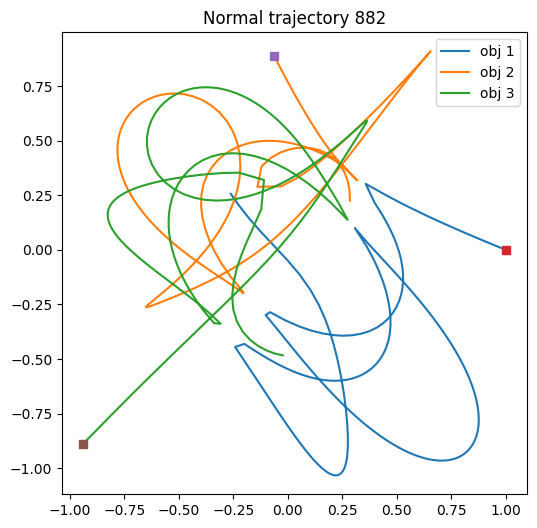

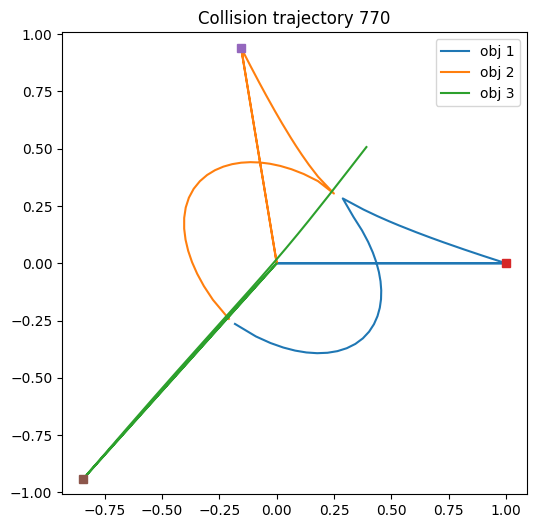

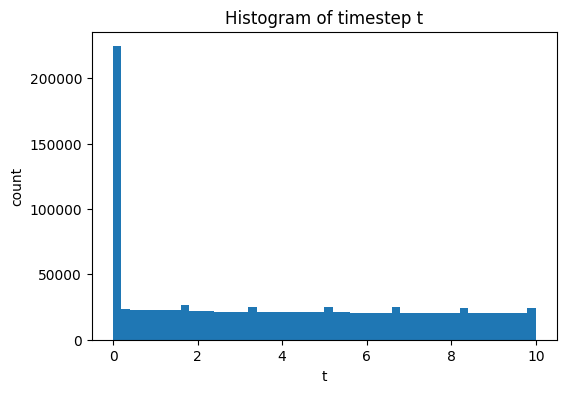

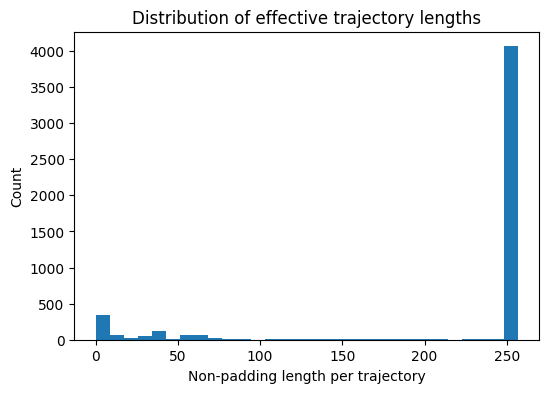

In [67]:
# Pré-processar o train
train = preprocess_train(data, steps_per_traj=257)

# Tabela-resumo (cola nos slides)
overview = dataset_overview(train)
display(overview)

# Verificação: velocidades iniciais ~ 0
init_vel_check = check_initial_velocities_zero(train)
display(init_vel_check)

# Visualizações: 1 trajetória “normal”
plot_one_trajectory(train, traj_id=None, title_prefix="Normal trajectory")

# Visualizações: 1 trajetória com colisão (se existir)
col_traj = find_collision_traj(train)
if col_traj is not None:
    plot_one_trajectory(train, traj_id=col_traj, title_prefix="Collision trajectory")
else:
    print("No collision trajectories found (no padding).")

# Histograma de t
plot_t_hist(train)

# Distribuição do comprimento útil (sem padding) por trajetória
plot_hist_nonpadding_lengths(train)


<h3>✂️ Custom Split by Trajectory</h3>

In [68]:
FEATURES = ["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]
TARGETS  = ["x_1","y_1","x_2","y_2","x_3","y_3"]

def make_train_val_test_split(
    train_df: pd.DataFrame,
    features: list = FEATURES,
    targets: list  = TARGETS,
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42
):
    """
    Divide em 70% treino, 15% validação e 15% teste (interno).
    Devolve:
      X_tr, y_tr, X_va, y_va, X_te, y_te → arrays numpy
      tr, va, te → DataFrames (úteis para análise/plots)
    Exclui padding do treino/validação/teste.
    """
    # garantir que as frações somam 1
    assert abs(train_size + val_size + test_size - 1.0) < 1e-8, "frações devem somar 1"

    # embaralhar trajetórias
    unique_traj = np.array(train_df["traj_id"].unique())
    np.random.seed(random_state)
    np.random.shuffle(unique_traj)

    n_total = len(unique_traj)
    n_train = int(train_size * n_total)
    n_val   = int(val_size * n_total)

    tr_ids = unique_traj[:n_train]
    va_ids = unique_traj[n_train:n_train+n_val]
    te_ids = unique_traj[n_train+n_val:]

    # filtrar cada subconjunto (sem padding)
    tr = train_df[(train_df["traj_id"].isin(tr_ids)) & (~train_df["is_padding"])].copy()
    va = train_df[(train_df["traj_id"].isin(va_ids)) & (~train_df["is_padding"])].copy()
    te = train_df[(train_df["traj_id"].isin(te_ids)) & (~train_df["is_padding"])].copy()

    X_tr, y_tr = tr[features].values, tr[targets].values
    X_va, y_va = va[features].values, va[targets].values
    X_te, y_te = te[features].values, te[targets].values

    return X_tr, y_tr, X_va, y_va, X_te, y_te, tr, va, te


# executar split
X_tr, y_tr, X_va, y_va, X_te, y_te, tr_df, va_df, te_df = make_train_val_test_split(train)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)
print("Test: ", X_te.shape, y_te.shape)

Train: (768065, 7) (768065, 6)
Val:   (157867, 7) (157867, 6)
Test:  (163858, 7) (163858, 6)


<h3>📝 Task 1.2</h3>

<h3>🔎 Baseline Model (Linear Regression)</h3>

In [69]:
# pipeline: StandardScaler (normalização) + LinearRegression
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())

baseline.fit(X_tr, y_tr)  # treino
y_hat = baseline.predict(X_va)  # previsão no validation

# métrica RMSE (root mean squared error)
rmse = mean_squared_error(y_va, y_hat, squared=False)
print("Baseline RMSE (validation split):", rmse)

Baseline RMSE (validation split): 1.270862432188997


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<h3>📊 y–ŷ Plot Helper</h3>

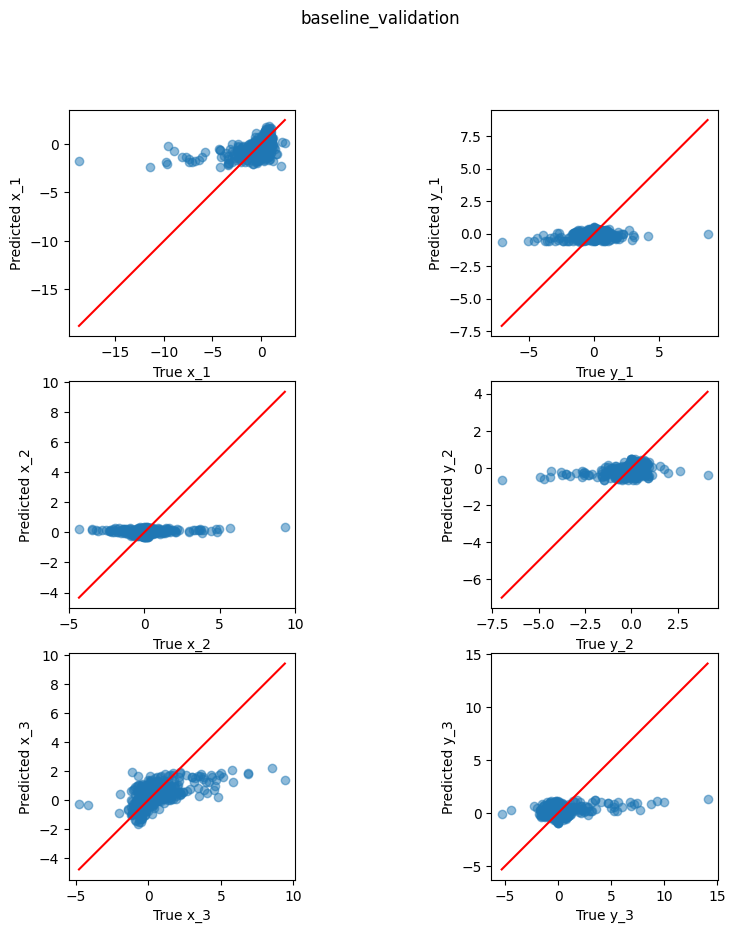

In [70]:
def plot_y_yhat(y_true, y_pred, plot_title="y_vs_yhat"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    idx = np.random.choice(len(y_true), MAX, replace=False) if len(y_true) > MAX else np.arange(len(y_true))

    pyplot.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_true[idx,i]); x1 = np.max(y_true[idx,i])
        pyplot.subplot(3,2,i+1)
        pyplot.scatter(y_true[idx,i], y_pred[idx,i], alpha=0.5)
        pyplot.xlabel('True ' + labels[i]); pyplot.ylabel('Predicted ' + labels[i])
        pyplot.plot([x0,x1],[x0,x1], color='red')  # linha identidade
        pyplot.axis('square')
    pyplot.suptitle(plot_title)
    pyplot.savefig(plot_title+'.pdf')  # guarda também para slides
    pyplot.show()

# usar no validation set
plot_y_yhat(y_va, y_hat, plot_title="baseline_validation")


<h3>📤 Generate Kaggle Submission</h3>

In [71]:
# preparar dataset completo para treino
full = train[~train["is_padding"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

# pipeline baseline re-treinado em todo o dataset
baseline_full = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_full.fit(X_full, y_full)

# preparar X_test
X_test = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = baseline_full.predict(X_test)

# construir submissão no formato correto
submission = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
submission.to_csv("baseline-model.csv", index=False)
print("Saved submission file: baseline-model.csv"),


Saved submission file: baseline-model.csv


(None,)